# AMR SKID-STEERING PROJECT
### Notebook contents
* Kinodynamic RRT* implementation
### Notebook contributors
* Mattia Castelmare
* Andrea Giuseppe Di Francesco
* Enrico Fazzi

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
from utils import *
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy import optimize
from RK4 import *

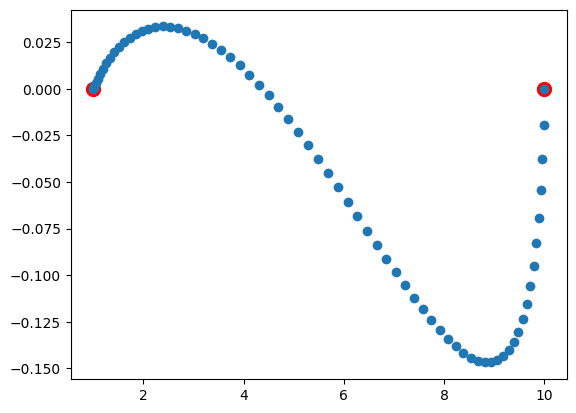

In [13]:
class KinoDynamicTrajectoryPlanner:

    def __init__(self, qi, qf):

        self.qi = qi
        self.qf = qf

        self.A, self.B, self.R = self.get_AB(self.qf[3][0], self.qf[4][0], self.qf[2][0]) # Linearize around the final state qf


        self.q_d_0 = self.get_state(self.qf[3][0], self.qf[4][0], self.qf[2][0], 0, 0) # Computed with the zero inputs
        
        self.c = self.q_d_0 - self.A @ self.qf
      
        
        
        
    def plan_opt_traj(self):


        tau = 0.0
        tau_step = 1
        interstar = 0
        iter_max = 1000000

        c = np.zeros((iter_max))
        xbar = np.zeros((iter_max, *self.qi.shape))
        G = np.zeros((iter_max, *self.A.shape))

        c[interstar] = np.inf
        G[0] = np.zeros((self.A.shape))
        iter = 0
        xbar[0] = self.qi
        while tau < c[interstar]:
            
            tau+= tau_step
            iter += 1
            xbar[iter] = self.our_RK4(self.x_bar, xbar[0], tau)
            G[iter] = self.our_RK4(self.G_func, G[0], tau)
            

            c[iter] = self.compute_cost(G[iter], xbar[iter], tau)
            

            if c[iter] < c[interstar]:
                interstar = iter
                taustar = tau

        # print('Found time: ', taustar)
        d_ = np.linalg.inv(G[interstar]) @ (self.qf - xbar[interstar])
        # print(self.qf.shape, d_.shape)
        state_f = np.concatenate([self.qf, d_])
        self.confs, self.ys = self.our_BKRK4(self.ODE_state_rec, state_f, taustar)
        pre_c = np.linalg.inv(self.R) @ self.B.T
        pre_c = np.expand_dims(pre_c, axis = 0)

        pre_c = np.repeat(pre_c, self.confs.shape[0], axis = 0)

        self.commands = pre_c @ self.ys
        self.cost = c[interstar]

        # Flipping the arrays:
        self.confs = np.flip(self.confs, axis = 0)
        self.commands = np.flip(self.commands, axis = 0)

        return self.confs[-1]
    
    def get_state(self, eta1, eta2, theta, u1, u2):
        ''' This function return the state of the system:
        
            args: eta1, eta2, theta, u1, u2: Configuration space;

            output: q = current state computed in eta1, eta2, theta, u1, u2
        '''

        q = np.array([[math.cos(theta)*eta1 - math.sin(theta)*eta2],
                    [math.sin(theta)*eta1 + math.cos(theta)*eta2],
                    [-(1/d0)*eta2],
                    [u1],
                    [u2]])

        return q


    def get_derivative(self, q, u):
        ''' Compute the Kinematic model in a configuration q with a control input u'''
        qd = self.A @ q + self.B @ u + self.c

        return qd
    
    
    def ODE_state_rec(self, state):
        ''' This function computes the ODE to reconstruct the state, 5 variables are for the configuration q, and 5 for y. (Details in the paper) 

            args: state [10 x 1]

            output: [q_d, y_d]; concatenated transition vector.
        
        '''
        q_d = self.A @ state[:5, :] + self.B @ np.linalg.inv(self.R) @ self.B.T @ state[5:, :] + self.c
        y_d = - self.A.T @ state[5:, :]

        return np.concatenate([q_d, y_d])

    def get_AB(self, eta1, eta2, theta):
        ''' This function return the A matrix that linearize the reduced kinematics in the skid-steering Robot :
        
            args: eta1, eta2, theta: Configuration space;

            output: A, B, R matrices
        '''

        A = np.array([[0, 0, -math.sin(theta)*eta1 - math.cos(theta)*eta2, math.cos(theta), -math.sin(theta)],
                    [0, 0, math.cos(theta)*eta1 - math.sin(theta)*eta2, math.sin(theta), math.cos(theta)],
                    [0, 0, 0, 0, -(1/d0)],
                    [0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0]])
        
        B = np.array([[0, 0],
                    [0, 0],
                    [0, 0],
                    [1, 0],
                    [0, 1]])
        
        R = np.array([[1, 0],
                    [0, 1]])

        
        return A, B, R



    def G_func(self, G_):
        
        ''' This function computes "The weighted controllability Gramian", given the A, B and R matrix of a system
            for which we aim to minimize a trajectory w/ fixed-final-state-fixed-final-time. 
            
            args: A, B: Linearized dynamics of the skid-steering Robot ; R: Weights matrix of the control inputs ; t: independent variable 

            output: G_: not integrated Weighted controllability Gramian matrix

        '''

        G_d = self.A @ G_ + G_ @ self.A.T + self.B @ np.linalg.inv(self.R) @ self.B.T #transition function
        
        
        return G_d
    
    # def our_RK4(self, f, x0, dt):
    #     k1 = f(x0)
    #     k2 = f(x0 + k1 * dt / 2.0)
    #     k3 = f(x0 + k2 * dt / 2.0)
    #     k4 = f(x0 + k3 * dt)
    #     yf = x0 + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    #     return yf

    def our_RK4(self, f, y0, tf):
        ''' This function computes a forward integration based on the 4-th order Runga-Kutta method 
        
            args: (f: Transition state function) ; (yf: Initial conditions) ; (tf: Final timestep)

            output: (y[-1]: Last value of the integrated function in tf)
        
        '''
        t = np.linspace(0, tf, int(tf*10))
        n = len(t)
        y = np.zeros((n, *y0.shape))
        y[0] = y0
        for i in range(n - 1):
            h = t[i+1] - t[i]
            k1 = f(y[i])
            k2 = f(y[i] + k1 * h / 2.)
            k3 = f(y[i] + k2 * h / 2.)
            k4 = f(y[i] + k3 * h)
            y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)

        return y[-1]
    
    def our_BKRK4(self, f, yf, tf):
        ''' This function computes a backward integration based on the 4-th order Runga-Kutta method 
        
            args: (f: Transition state function) ; (yf: Final conditions) ; (tf: Initial timestep)

            output: (q: [N x state_variables x 1], trajectory of configurations in the Robot); (y_: [N x state_variables x 1], variable to compute the control inputs)
        
        '''
        t = np.linspace(tf, 0, int(tf*10))
        n = len(t)
        y = np.zeros((n, *yf.shape))
        q = np.zeros((n, *self.qf.shape))
        y_ = np.zeros((n, *self.qf.shape))

        y[0] = yf
        q[0] = yf[:self.qf.shape[0]]
        y_[0] = yf[self.qf.shape[0]:]

        for i in range(n - 1):
            h = t[i+1] - t[i]
            k1 = f(y[i])
            k2 = f(y[i] + k1 * h / 2.)
            k3 = f(y[i] + k2 * h / 2.)
            k4 = f(y[i] + k3 * h)
            y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
            q[i+1] = y[i+1][:self.qf.shape[0]]

            q[i+1][2] = 0 # Imposing theta equal to 0 doesn't change the trajectory
                        
            y_[i+1] = y[i+1][self.qf.shape[0]:]

        return q, y_



    def x_bar(self, x_):
        ''' This function computes the free evolution of the state x at time t with no control input in the current state 
        
            args: A, c, t: A: jacobian of the transition state function, c : Constant part of the transition state function, t: independent variable

            output: x_b
        
        '''

        x_b_d = self.A @ x_ + self.c

        return x_b_d

    def compute_cost(self, G, xb, t):
        ''' This function implements the cost function for the KINODYNAMIC RRT* 

            args: t: independant variable

            output: c_d: Cost function objective if the path last a time t
        
        '''
        
        c = t + (self.qf - xb).T @ np.linalg.inv(G) @ (self.qf - xb)
        
        return c
    
    def cost_derivative(self, t):
        ''' This function implements the derivative of the cost function for the KINODYNAMIC RRT* 

            args: t: independant variable, x1: Final configuration, x0: Initial Configuration, A: A matrix of the system, B: B matrix of the system,
                R: Weight matrix of the control inputs, c: Constant values in the system/linearized system.

            output: c_d: Derivative of the cost function, we look for its roots in get_tau_max()
        
        '''

        d_t = self.d_tau(t)
        c_d = 1 - 2*(self.A @ self.qf + self.c).T @ d_t - d_t.T @ self.B @ np.linalg.inv(self.R) @ self.B.T @ d_t

        return c_d #[0][0]


    
X_i = 1
Y_i = 0
theta_i = 0
eta1_i = 0
eta2_i = 0 

u1_i = 0.001
u2_i = 0.002

X_f = 10
Y_f = 0
theta_f = 0 
eta1_f = 0.1
eta2_f = 0.2


qi = np.array([[X_i], [Y_i], [theta_i], [eta1_i], [eta2_i]]) 

qf = np.array([[X_f], [Y_f], [theta_f], [eta1_f], [eta2_f]]) 

rrt = KinoDynamicTrajectoryPlanner(qi, qf)

rrt.plan_opt_traj()
plt.scatter([X_i, X_f], [Y_i, Y_f], c = 'red', s = 100)
plt.scatter([x[0] for x in rrt.confs], [y[1] for y in rrt.confs])


plt.show()

## RRT* Algorithm

In [3]:
class Node:
    def __init__(self, state):

        self.state = state
        self.x = state[0][0]
        self.y = state[1][0]

    

        self.parent = None
        self.cost = None

        self.commands = None
        self.conf = None
        self.Time = None


class KynoDynamicRRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters):

        self.node_s = Node(start)
        self.node_g = Node(goal)

        ##################### INITIAL CONDITION #################
 
        self.node_s.Time = 0
        self.node_s.cost = 0


        self.node_s.confs = np.array([[start[0], start[1]]])
        self.node_g.confs = np.array([[goal[0], goal[1]]])

        #########################################################

        self.env = env
        self.n_iters = n_iters
        self.step = step
        self.prob_gs = prob_gs  # Empirical value
        self.utils = Utils()
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g)
        
        # Empirical values
        self.radius = max(self.env.x_range[-1], self.env.y_range[-1])//20
        self.trav_map = np.clip(np.random.normal(3, 8, size=(50, 30)), 2, 100)

    def planning(self):
        ''' This function computes the RRT* motion planning, thanks to the utilies and KinoDynamic RRT*;
            args: ............................................................................................
            output: 
        '''
        for iter in range(self.n_iters):
            if iter % 20 == 0:
                print("ITERATION OF PLANNING N°: ",iter)
  
            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue
            


            traj_planner = KinoDynamicTrajectoryPlanner(n_nearest.state, n_new.state) # From nearest to new
            n_new_state = traj_planner.plan_opt_traj()
            
            c = False
            for n in range(traj_planner.confs.shape[0]):
                if self.utils.is_inside_obs_alternative((traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])):
                    c = True
            if c:
                continue

            n_new = Node(n_new_state)
            if not self.utils.is_collision(n_nearest, n_new) and int(n_new.x) in range(0, self.env.x_range[-1]) and int(n_new.y) in range(0, self.env.y_range[-1]):
                
                # Assign to node velocity, acceleration and commands
             
                n_new.commands = traj_planner.commands
                n_new.confs = traj_planner.confs
                n_new.cost = self.compute_cost(traj_planner.confs)

                N_near = self.compute_NN(n_new, near=True)
                # N_near = self.Tree
                n_min, cost_min, n_new = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)

        path = [[self.node_g]]
        goal_state = self.get_goal_state()

        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "rrt*, N = " + str(self.n_iters), steer = False, steer2 = True)

    def choose_parent(self, N_near, n_nearest, n_new):
        ''' This function change the parent of n_new, starting with an initial guess on its nearest neighbor.;
            args: (N_near : List of n_new's neighbors), (n_nearest : n_new's initial guess as a parent.),
                  (n_new : Node object that need to be assigned at a node in N_near).
            output: 
        '''
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + n_new.cost#self.compute_cost(n_new.confs)

        for n_near in N_near:

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue

            traj_planner = KinoDynamicTrajectoryPlanner(n_near.state, n_new.state) # From nearest to new
            # n_new_state = traj_planner.plan_opt_traj()
            traj_planner.plan_opt_traj()
            c = False
            for n in range(traj_planner.confs.shape[0]):
                if self.utils.is_inside_obs_alternative((traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])):
                    c = True
            if c:
                continue

            # n_new_tr = Node(n_new_state)
            n_new_tr = copy.copy(n_new)

            if not self.utils.is_collision(n_near, n_new_tr) and int(n_new_tr.x) in range(0, self.env.x_range[-1]) and int(n_new_tr.y) in range(0, self.env.y_range[-1]):

                inter_cost = n_near.cost + \
                   self.compute_cost(traj_planner.confs) # traj_planner.cost # Intermediate cost
                if inter_cost < cost_min:
                    n_parent = n_near         # New best alternative
                    cost_min = inter_cost

                    
                    n_new.confs = traj_planner.confs
                    n_new.commands = traj_planner.commands
                    n_new.cost = inter_cost

                    n_new.x, n_new.y = n_new_tr.x, n_new_tr.y

                

        return n_parent, cost_min, n_new

    def rewire(self, N_near, n_parent, n_new):
        ''' This function change the parent of the n_new's neighbors iff n_new is a better parent than their current ones. ;
            args: (N_near : List of n_new's neighbors), (n_parent : n_new's parent is not considered in the computation.),
                  (n_new : Candidate parent, for the nodes in N_near).
            output: ........................................................................................................
        '''

        for n_near in N_near:
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue
            
            traj_planner = KinoDynamicTrajectoryPlanner(n_new.state, n_near.state) # From nearest to new
            # z_near_state = traj_planner.plan_opt_traj()
            traj_planner.plan_opt_traj()
            c = False
            for n in range(traj_planner.confs.shape[0]):
                if self.utils.is_inside_obs_alternative((traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])):
                    c = True
            if c:
                continue
            # z_near = Node(z_near_state)
            z_near = n_near

            if not self.utils.is_collision(z_near, n_new) and int(z_near.x) in range(0, self.env.x_range[-1]) and int(z_near.y) in range(0, self.env.y_range[-1]):

                if n_new.cost + self.compute_cost(traj_planner.confs) < n_near.cost: #traj_planner.cost

                    z_near.parent = n_new
                    z_near.cost = n_new.cost + traj_planner.cost #self.compute_cost(n_new_traj)

                    # n_near_old_idx = self.Tree.index(n_near)
                    # self.Tree[n_near_old_idx] = z_near

                    z_near.commands = traj_planner.commands
                    z_near.confs = traj_planner.confs

                    self.Tree.append(z_near)

        return

    def compute_NN(self, n_curr, near=False):
        ''' This function has two main objectives, either to compute a nearest neighbor, and also to compute a set of nearest neighbors. ;
            args: (n_curr : Node object, current node), (near : If True, are computed the neighbors for n_curr given a certain radius.)
            output: n_nearest, n_new XOR node_list
        '''
        # CHECK COLLISION
        dist_list = np.array([self.compute_dist_NN(n_curr, n_tree)
                             for n_tree in self.Tree])

        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)

            state = np.array([[(n_nearest.x + dist*math.cos(theta))], [(n_nearest.y + dist*math.sin(theta))],
                               [n_curr.state[2][0]], [n_curr.state[3][0]], [n_curr.state[4][0]]])
   
            n_new = Node(state)

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < self.radius]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:
            x_new = np.random.uniform(self.env.x_range[-1])
            y_new = np.random.uniform(self.env.y_range[-1])
            theta_new = np.random.uniform(low = -math.pi, high = +math.pi)
            xd_new = np.random.uniform(low = -max_vel, high = +max_vel)
            yd_new = np.random.uniform(low = -max_vel, high = +max_vel)

            state = np.array([[x_new], [y_new], [theta_new], [xd_new], [yd_new]])
         
            return Node(state)

        return self.node_g

    def get_goal_state(self):
        ''' This function the closest state to the goal state, that was found during the algorithm;
            args: ........................................................................
            output: goal_state: Node object
        '''
        dist_list = np.array([self.compute_dist_NN(node, self.node_g)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):
        ''' This function fills the path between the start and goal state, it considers that each node has a parent ;
            args: (path : empty path), (goal_state : pre-computed goal node, which is the closest to the actual goal node.)
            output: path : complete path e.g. [[Node_g], [Node_g-1], ......, [Node_start]]
        '''
        n_curr = goal_state
        while n_curr.x != self.node_s.x and n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent
        path.append([n_curr])

        return path

    def compute_dist_NN(self, n1, n2):
        ''' This function computes the euclidean distance between two object of the Node class 
            args: n1, n2 : n_i is an instance of Node ;
            
            output: dist : Total distance (m)

        '''
        dist = math.sqrt((n1.x-n2.x)**2 + (n1.y-n2.y)**2)
        return dist

    def compute_dist(self, conf):
        ''' This function takes a trajectory of positions, and computes the distance (m) the links these coordinates 
            args: conf : [(x_0, y_0), (x_1, y_1), ......, (x_f, y_f)];
            
            output: dist : Total distance (m)

        '''
        dist = 0

        dist_func = lambda p1, p2: math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

        for pt in range(1, conf.shape[0]):
            dist += dist_func(conf[pt], conf[pt - 1])
        return dist

    def compute_cost(self, conf):
        ''' This function takes a trajectory of positions, and computes the cost to do such trajectory, it is also used an elevation map. 
            args: conf : np.array([[x_0, y_0, theta_0, eta10, eta20],.....,[x_f, y_f, theta_f, eta1f, eta2f]];
            
            output: cost : Total distance (m)

        '''
        # # Elevation on the real map
        # n1_trav = self.trav_map[int(conf[-1][0]), int(conf[-1][1])]
        # n2_trav = self.trav_map[int(conf[0][0]), int(conf[0][1])]

        # increm = n2_trav - n1_trav  # Elevation between the two points
        plan_dist = self.compute_dist(conf)  # Planar distance

        # cost = math.sqrt(plan_dist**2 + increm**2)
        cost = plan_dist

        return cost

        
    

 

In [4]:
env = Env(x_bounds=x_bounds, y_bounds=y_bounds)
    

theta_i = math.atan2(goal[1] -goal[0],start[1] - start[0])
eta1_i = 0
eta2_i = 0 

u1_i = 0.001
u2_i = 0.002

theta_f = 0 
eta1_f = 0.1
eta2_f = 0.2
qi = np.array([[start[0]], [start[1]], [theta_i], [eta1_i], [eta2_i]]) 

qf = np.array([[goal[0]], [goal[1]], [theta_f], [eta1_f], [eta2_f]]) 
rrt = KynoDynamicRRT_STAR(qi, qf, env, step, prob_gs, n_iters) 

In [5]:
e = rrt.planning()


ITERATION OF PLANNING N°:  0
ITERATION OF PLANNING N°:  20
ITERATION OF PLANNING N°:  40
ITERATION OF PLANNING N°:  60


KeyboardInterrupt: 

In [6]:
path = rrt.tot_path
plt.scatter([x[0].confs[i][0][0] for x in path for i in range(x[0].confs.shape[0])], [
                         x[0].confs[i][1][0] for x in path for i in range(x[0].confs.shape[0])], s = 2, c = 'blue')#'-r', linewidth=1)
conf = path
# plt.scatter([x[0].conf[-1][0] for x in conf], [
#             x[0].conf[-1][1] for x in conf], s = 30, c = 'red')

AttributeError: 'list' object has no attribute 'shape'

In [6]:
rrt.compute_cost()

NameError: name 'e' is not defined